In [ ]:
pip install transformers

In [ ]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split

import os
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# preprocessing


In [ ]:
# train data load
df = pd.read_csv('/content/drive/MyDrive/chatbot_data/final.csv', encoding='cp949')
df = df.iloc[:,0:3]
df

,질문1,질문2,유사도
0,고려청자가 처음 만들어진 시기 알려줘,산수무늬 뭘까?,0
1,표형병 알려줘,뇌문 알려줘,0
2,우리나라에서 도자기를 맨처음 만든사람이 누구에요?,구름 용무늬 항아리 설명,0
3,대나무무늬 설명,도침 알려줘,0
4,도자기가 변화한 순서를 알려주세요.,토제소상 설명,0
...,...,...,...
23627,문자무늬모양,문자무늬,1
23628,문자무늬모양,문자무늬 궁금해,1
23629,문자무늬 뭘까?,문자무늬,1
23630,문자무늬 뭘까?,문자무늬 궁금해,1


In [ ]:
#test data split
train_data, dev_data = train_test_split(df, test_size=0.1, shuffle=True, stratify=df['유사도'], random_state=0)

In [ ]:
#BERT 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased",
                                          do_lower_case=False)

In [ ]:
#random seed 고정
tf.random.set_seed(0)
np.random.seed(0)

# BASE PARAM 지정
BATCH_SIZE = 32
NUM_EPOCHS = 100
MAX_LEN = 35 # 최대 문장길이의 2배

In [ ]:
# tokenizer 함수
def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # 2개의 문장을 input 으로 받는다
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # '[CLS]','[SEP]' token 추가
        max_length = MAX_LEN,   # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

# 정규표현식을 사용해서 특수문자 제거

def clean_text(sent):
    sent_clean = re.sub("[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]", " ", sent)
    return sent_clean

In [ ]:
# train set 전처리
# 전처리 후 list
input_word_ids = []
input_mask = []
input_type_ids = []
data_labels = []

for sent1, sent2, score in train_data[['질문1', '질문2', '유사도']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_word_ids.append(input_id)
        input_mask.append(attention_mask)
        input_type_ids.append(token_type_id)
        data_labels.append(score)
        
    # error 대비
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
train_input_word_ids = np.array(input_word_ids, dtype=int)
train_input_mask = np.array(input_mask, dtype=int)
train_type_ids = np.array(input_type_ids, dtype=int)
train_inputs = (train_input_word_ids, train_input_mask, train_type_ids)
train_data_labels = np.array(data_labels)

In [ ]:
# validation 전처리
# train과 같은방식으로 전처리 
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in dev_data[['질문1', '질문2', '유사도']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)


# model 

In [ ]:
# BERT classification model

class TFBertClassification(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassification, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path) # pre-trained model 불러오기
        self.num_class = num_class 
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classification = tf.keras.layers.Dense(self.num_class, activation='sigmoid',
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classification")
        
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classification(pooled_output)

        return logits

In [ ]:
classification_model = TFBertRegressor(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=1)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(3e-5)
# loss = tf.keras.losses.MeanSquaredError()
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
#학습 진행하기
model_name = "tf2_BERT"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001,patience=5,mode='min')

checkpoint_path = os.path.join('/content/drive/MyDrive/', model_name, 'weights.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

/content/drive/MyDrive/tf2_BERT -- Folder create complete 



In [ ]:
# 학습과 eval 시작
history = classification_model.fit(train_inputs, train_data_labels, epochs=10,
            validation_data = (dev_inputs, dev_data_labels),
            batch_size=32, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

Epoch 1/10
665/665 [==============================] - 227s 341ms/step - loss: 0.0977 - accuracy: 0.9714 - val_loss: 0.0199 - val_accuracy: 0.9953

Epoch 00001: val_accuracy improved from -inf to 0.99535, saving model to /content/drive/MyDrive/tf2_BERT/weights.ckpt
Epoch 2/10
665/665 [==============================] - 230s 345ms/step - loss: 0.0251 - accuracy: 0.9932 - val_loss: 0.0146 - val_accuracy: 0.9966

Epoch 00002: val_accuracy improved from 0.99535 to 0.99662, saving model to /content/drive/MyDrive/tf2_BERT/weights.ckpt
Epoch 3/10
665/665 [==============================] - 242s 363ms/step - loss: 0.0125 - accuracy: 0.9965 - val_loss: 0.0212 - val_accuracy: 0.9932

Epoch 00003: val_accuracy did not improve from 0.99662
Epoch 4/10
665/665 [==============================] - 226s 340ms/step - loss: 0.0106 - accuracy: 0.9959 - val_loss: 0.0189 - val_accuracy: 0.9962

Epoch 00004: val_accuracy did not improve from 0.99662
Epoch 5/10
665/665 [==============================] - 226s 340m

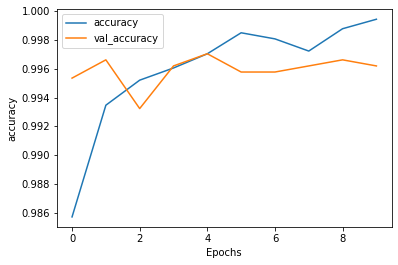

In [ ]:
plot_graphs(history, 'accuracy')

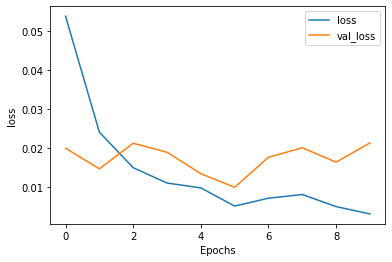

In [ ]:
plot_graphs(history, 'loss')

# Test

In [ ]:
# Load Test dataset
test_data  = pd.read_csv('/content/drive/MyDrive/chatbot_data/test_set.csv',encoding='cp949')
test_data = test_data.iloc[:,:3].dropna()

In [ ]:
# Test set도 똑같은 방법으로 구성
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in test_data[['질문1', '질문2', '유사도']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.array(data_labels)

In [ ]:
print("# sents: {}, # labels: {}".format(len(test_input_ids), len(test_data_labels)))

# sents: 870, # labels: 870


In [ ]:
results = classification_model.evaluate(test_inputs, test_data_labels, batch_size=512)
print("test loss, test accuracy: ", results)

2/2 [==============================] - 2s 746ms/step - loss: 0.1799 - accuracy: 0.9674
test loss, test pearson correlation:  [0.1823945790529251, 0.9666666388511658]


In [ ]:
y = classification_model.predict(test_inputs)

a = []

for i in y:
    if i > 0.5:
        a.append(1)
        
    else:
        a.append(0)

print(a)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(a,test_data_labels)
cm

array([[504,   3],
       [ 26, 337]])

In [ ]:
# cm 구현 함수

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[504   3]
 [ 26 337]]


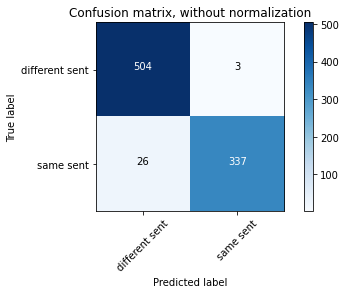

In [ ]:
plt.figure()
plot_confusion_matrix(cm, ['different sent','same sent'], title='Confusion matrix, without normalization')
plt.savefig('DenseNet_cm.jpg')